In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [3]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv", index_col=0) 
df2=pd.read_csv("WBA.csv", index_col=0)  
df3=pd.read_csv("MTRAF.csv", index_col=0)
df4=pd.read_csv("COOP.csv", index_col=0) 
df5=pd.read_csv("JSAIY.csv", index_col=0)  
df6=pd.read_csv("ADRNY.csv", index_col=0)  
df7=pd.read_csv("TSCDY.csv", index_col=0)  
df8=pd.read_csv("KR.csv", index_col=0)    
df9=pd.read_csv("AGHC.csv", index_col=0)  
df10=pd.read_csv("CRRFY.csv", index_col=0) 
df11=pd.read_csv("WNGRF.csv", index_col=0) 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df3

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,27.500000,27.500000,27.500000,27.500000,25.340036,300
1,2016-01-05,27.500000,27.500000,27.500000,27.500000,25.340036,0
2,2016-01-06,27.190001,27.420000,27.190001,27.420000,25.266321,200
3,2016-01-07,27.020000,27.020000,27.020000,27.020000,24.897738,100
4,2016-01-08,27.240000,27.440001,27.219999,27.430000,25.275537,4200
...,...,...,...,...,...,...,...
1001,2019-12-24,41.259998,41.259998,41.259998,41.259998,40.273190,0
1002,2019-12-26,41.259998,41.259998,41.259998,41.259998,40.273190,0
1003,2019-12-27,41.259998,41.259998,41.259998,41.259998,40.273190,0
1004,2019-12-30,41.259998,41.259998,41.259998,41.259998,40.273190,0


# Make models (train)

In [4]:
from keras.layers import *
def make_models(all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], output_vars=[2], 
                outputs_company=1, train_size=754, time_step=60, epochs=30, units=50, batch_size=64, volume_switch=False,): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  # Show arguments
  inputs=['-', 'Open', 'High', 'Low', 'Close', '-', 'Volume']
  print(f"[Arguments]") 
  print(f"num_company={len(company_list)}社 {company_list}")
  print(f"input_variables={input_category}, ====> output_variables={output_category}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}, batch_size={batch_size}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. normalise data
  #3. prepare both training_data and label depending on the number of inputs and outputs
  X_train=[]
  y_trains=[]
  

  training_set_all=np.hstack((data[:,:] for data in train_data))
  print(f"training_set_all={training_set_all.shape}") # (754, company_list * input_vars)
  
  ss_all=[]
  for i in range(training_set_all.shape[1]):
    ss1=StandardScaler()
    ss_all.append(ss1.fit_transform(training_set_all[:,i].reshape(-1, 1)))
  concat=np.hstack(ss_all)

  index=[]
  for i in range(len(output_vars)):
    index+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*(len(input_vars)), len(input_vars))] 
  print(index)
  
  for l in range(time_step, train_size):
    X_train.append(concat[l-time_step: l, :])
    for m in range(len(index)):
      y_trains.append(concat[l, index[m]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")

  #4. modify y_train based on the number of companies
  y_trains2=[]
  
  if len(output_vars) != 1:
    for x in range(len(all_data)*len(output_vars)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(all_data*len(output_vars)))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(all_data)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(all_data))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  #5. make models

  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=batch_size)
    model_lists.append(model)
    print("")

  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [5]:
# Make predictions
def make_preds(model_lists, y_trains2, all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], 
               output_vars=[2], train_size=754, time_step=60, cm_switch=False, volume_switch=False):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")

  #1. Prepare test_data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  
  inputs = []
  for m in range(len(all_data)): 
    inputs.append(all_data[m].iloc[:, input_vars][len(all_data[m])-len(test_data[m])-time_step:].values)
  inputs = np.array(inputs)

  #2. normalise
  variables=[]
  ss=[]
  for i in range(len(all_data)):
    for j in range(len(input_vars)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # Use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])
  X_test = np.array(X_test)

  #3. make predictiions
  preds = [] 
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_vars)==1:
    ind=[i for i in range(input_vars.index(output_vars[0]), len(all_data)*len(input_vars), len(input_vars))]
  else:
    ind=[]
    for i in range(len(output_vars)):
      ind+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*len(input_vars), len(input_vars))]
 
  #4. scale_back normalise
  for p in range(len(y_trains2)):
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) 
  preds = np.array(preds)

  #5. plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_vars)):
    actual_lists_test+=[sc.iloc[train_size:,output_vars[dd]] for sc in all_data]
    actual_lists_train+=[sc.iloc[:train_size,output_vars[dd]] for sc in all_data]
  
  if len(output_vars) > 1:
    R2=company_list*len(output_vars) # lists of companies
  else: R2=company_list
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(all_data)-1, len(R2), len(all_data))]

  plt.figure(figsize=(18, 35))
  scores_list=[]
  for p in range(len(R2)):
    if len(company_list) >=9: plt.subplot(6, 2, p+1)
    else: plt.subplot(4, 2, p+1) 
    plt.plot(all_data[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(all_data[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(all_data[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    if input_vars[0]=="2": plt.ylabel('High Price')
    else: plt.ylabel('Volume')
    
    from sklearn.metrics import r2_score
    r2=round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)
    scores_list.append(r2)
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  # calcurate R2_average 
  if p in r:
    scores_list.append(round(R/len(all_data), 4))
    print(f"R2-{len(all_data)}companies_average={round(R/len(all_data), 4)}")
    R=0
  print(f"R2_scores_lists={scores_list}")
  print("")
  #6. Make confusion matrix
  columns = company_list # labeling 
  
  if cm_switch==True:
    for p in range(len(output_vars)):
      print(f"Preds_Heatmap='{output_category[p]}' correlation")
      prd=[preds[p] for p in range(len(company_list)*p, len(company_list)+p*len(company_list))]
      Preds= pd.DataFrame(np.concatenate(prd, axis=1))
      Preds.columns = columns
    
      plt.figure(figsize=(8, 6))
      cmap=sns.diverging_palette(220, 20, as_cmap=True)
      sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten() 


# Multivariate-sample(n=1)

In [78]:
from sklearn.preprocessing import StandardScaler
import numpy as np

df = df1
df_5=df[['High', 'Low', 'Volume']]
train_data=df_5.iloc[:754]
test_data=df_5.iloc[754:]
ss=StandardScaler()
n_train=ss.fit_transform(train_data)
n_test=ss.fit_transform(test_data)

time_step=60
X_train, y_train = [],[]
# Loop for training data
for i in range(time_step,train_data.shape[0]):
    X_train.append(n_train[i-time_step:i])
    y_train.append(n_train[i, 0])

X_train, y_train = np.array(X_train),np.array(y_train)
X_train.shape
# y_train.shape

(694, 60, 3)

In [48]:
def make_models(X_train, y_train, units, epochs, batch_size):
  
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.metrics import mean_squared_error
  from keras.callbacks import EarlyStopping

  model = Sequential()

  model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
  model.add(Dropout(0.2))

  model.add(LSTM(units = units, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = units, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = units, return_sequences = False))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
  return model

In [91]:
model = make_models(X_train, y_train, 60, 50, 32)

Epoch 1/50
22/22 [==============================] - 5s 17ms/step - loss: 0.6315
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3418
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3339
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3033
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2722
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2537
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2206
Epoch 8/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2546
Epoch 9/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2229
Epoch 10/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1839
Epoch 11/50
22/22 [==============================] - 0s 12ms/step - loss: 0.1916
Epoch 12/50
22/22 [==============================] - 0s 12ms/step - loss: 0.1653
Epoch 13/50
22/22 [==================

In [50]:
def predicts(model,test,timesteps):
  from sklearn.metrics import r2_score
  X_test = []
  Y_test = []

  # Loop for testing data
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i])
      Y_test.append(test[i][0])
  X_test,Y_test = np.array(X_test),np.array(Y_test)
  #print(X_test.shape,Y_test.shape)

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  r = r2_score(Y_test,Y_hat)

  return Y_test, Y_hat, r

In [51]:
def plot_data(Y_test,Y_hat):
  import matplotlib.pyplot as plt
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'], loc = 'lower right')
  plt.show()

(252, 3)
r2=89.59%


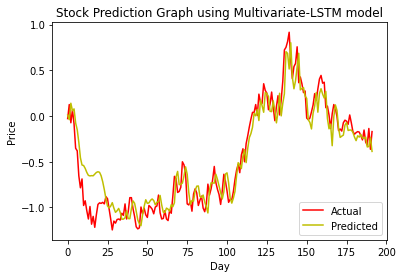

In [90]:
print(n_test.shape)
Y_test, Y_hat, r = predicts(model, n_test, 60)
print(f"r2={round(r*100, 2)}%")
plot_data(Y_test, Y_hat)